# Transfer Learning

In this notebook, you'll learn how to use pre-trained networks to solved challenging problems in computer vision. Specifically, you'll use networks trained on [ImageNet](http://www.image-net.org/) [available from torchvision](http://pytorch.org/docs/0.3.0/torchvision/models.html). 

ImageNet is a massive dataset with over 1 million labeled images in 1000 categories. It's used to train deep neural networks using an architecture called convolutional layers. I'm not going to get into the details of convolutional networks here, but if you want to learn more about them, please [watch this](https://www.youtube.com/watch?v=2-Ol7ZB0MmU).

Once trained, these models work astonishingly well as feature detectors for images they weren't trained on. Using a pre-trained network on images not in the training set is called transfer learning. Here we'll use transfer learning to train a network that can classify our cat and dog photos with near perfect accuracy.

With `torchvision.models` you can download these pre-trained networks and use them in your applications. We'll include `models` in our imports now.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import time
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models

Most of the pretrained models require the input to be 224x224 images. Also, we'll need to match the normalization used when the models were trained. Each color channel was normalized separately, the means are `[0.485, 0.456, 0.406]` and the standard deviations are `[0.229, 0.224, 0.225]`.

In [2]:
data_dir = 'Cat_Dog_data'

# TODO: Define transforms for the training data and testing data
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

# Pass transforms in here, then run the next cell to see how the transforms look
train_data = datasets.ImageFolder(data_dir + '/train', transform=train_transforms)
test_data = datasets.ImageFolder(data_dir + '/test', transform=test_transforms)

trainloader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True, \
                                          num_workers = 12)
testloader = torch.utils.data.DataLoader(test_data, batch_size=64, \
                                          num_workers = 12)

We can load in a model such as [DenseNet](http://pytorch.org/docs/0.3.0/torchvision/models.html#id5). Let's print out the model architecture so we can see what's going on.

In [11]:
model = models.densenet121(pretrained=True)
model

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplac

This model is built out of two main parts, the features and the classifier. The features part is a stack of convolutional layers and overall works as a feature detector that can be fed into a classifier. The classifier part is a single fully-connected layer `(classifier): Linear(in_features=1024, out_features=1000)`. This layer was trained on the ImageNet dataset, so it won't work for our specific problem. That means we need to replace the classifier, but the features will work perfectly on their own. In general, I think about pre-trained networks as amazingly good feature detectors that can be used as the input for simple feed-forward classifiers.

In [12]:
# Freeze parameters so we don't backprop through them
for param in model.parameters():
    param.requires_grad = False

from collections import OrderedDict
classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(1024, 500)),
                          ('relu', nn.ReLU()),
                          ('fc2', nn.Linear(500, 2)),
                          ('output', nn.LogSoftmax(dim=1))
                          ]))
    
model.classifier = classifier

With our model built, we need to train the classifier. However, now we're using a **really deep** neural network. If you try to train this on a CPU like normal, it will take a long, long time. Instead, we're going to use the GPU to do the calculations. The linear algebra computations are done in parallel on the GPU leading to 100x increased training speeds. It's also possible to train on multiple GPUs, further decreasing training time.

PyTorch, along with pretty much every other deep learning framework, uses [CUDA](https://developer.nvidia.com/cuda-zone) to efficiently compute the forward and backwards passes on the GPU. In PyTorch, you move your model parameters and other tensors to the GPU memory using `model.to('cuda')`. You can move them back from the GPU with `model.to('cpu')` which you'll commonly do when you need to operate on the network output outside of PyTorch. As a demonstration of the increased speed, I'll compare how long it takes to perform a forward and backward pass with and without a GPU.

In [13]:
for device in ['cpu', 'cuda']:

    criterion = nn.NLLLoss()
    # Only train the classifier parameters, feature parameters are frozen
    optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)

    model.to(device)

    for ii, (inputs, labels) in enumerate(trainloader):

        # Move input and label tensors to the GPU
        inputs, labels = inputs.to(device), labels.to(device)

        start = time.time()

        outputs = model.forward(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        if ii==3:
            break
        
    print(f"Device = {device}; Time per batch: {(time.time() - start)/3:.3f} seconds")

Device = cpu; Time per batch: 3.226 seconds
Device = cuda; Time per batch: 0.007 seconds


You can write device agnostic code which will automatically use CUDA if it's enabled like so:
```python
# at beginning of the script
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

...

# then whenever you get a new Tensor or Module
# this won't copy if they are already on the desired device
input = data.to(device)
model = MyModule(...).to(device)
```

From here, I'll let you finish training the model. The process is the same as before except now your model is much more powerful. You should get better than 95% accuracy easily.

>**Exercise:** Train a pretrained models to classify the cat and dog images. Continue with the DenseNet model, or try ResNet, it's also a good model to try out first. Make sure you are only training the classifier and the parameters for the features part are frozen.

In [3]:
model = models.densenet121(pretrained=True)

/home/eka/anaconda3/envs/deep-learning/lib/python3.6/site-packages/torchvision-0.2.1-py3.6.egg/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.


In [4]:
# Freeze parameters so we don't backprop through them
for param in model.parameters():
    param.requires_grad = False

from collections import OrderedDict
classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(1024, 500)),
                          ('relu', nn.ReLU()),
                          ('fc2', nn.Linear(500, 2)),
                          ('output', nn.LogSoftmax(dim=1))
                          ]))
    
model.classifier = classifier

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [6]:
model.to(device)
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)

epochs = 30
steps = 0

train_loss_epochs = []
test_loss_epochs = []
for e in range(epochs):
    tic = time.time()
    
    train_losses = []
    test_losses = []
    # set model back to train mode
    model.train()
    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)
        # Clear the gradients, do this because gradients are accumulated
        optimizer.zero_grad()
        # Forward and backward propagations
        log_ps = model(images)
        loss = criterion(log_ps, labels)
        loss.backward()
        optimizer.step()
        # Calculate train accuracy
        ps = torch.exp(log_ps)
        top_p, top_class = ps.topk(1, dim=1)
        equals = top_class == labels.view(top_class.shape)
        accuracy = torch.mean(equals.type(torch.FloatTensor)).item()
        train_losses.append(1-accuracy)
        
    else:
        ## TODO: Implement the validation pass and print out the validation accuracy
        # turn off gradients
        # Calculate test accuracy with gradient calculation off
        with torch.no_grad():
            # set model to evaluation mode
            model.eval()
            # validation pass here
            for images, labels in testloader:
                images, labels = images.to(device), labels.to(device)
                
                ps = torch.exp(model(images))
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(top_class.shape)
                accuracy = torch.mean(equals.type(torch.FloatTensor)).item()
                test_losses.append(1-accuracy)

    toc = time.time()
    print("epoch %2d, runtime %6.3f seconds" % (e + 1, toc - tic))
    train_loss_epoch = torch.mean(torch.tensor(train_losses))
    train_loss_epochs.append(train_loss_epoch.item())
    #bar print("    Training loss   : %5.2f" % train_loss_epoch)
    test_loss_epoch = torch.mean(torch.tensor(test_losses))
    test_loss_epochs.append(test_loss_epoch.item())
    #bar print("    Validation loss : %5.2f" % test_loss_epoch)

epoch  1, runtime 119.191 seconds
epoch  2, runtime 116.705 seconds
epoch  3, runtime 110.391 seconds
epoch  4, runtime 113.842 seconds
epoch  5, runtime 119.716 seconds
epoch  6, runtime 119.888 seconds
epoch  7, runtime 119.904 seconds
epoch  8, runtime 119.897 seconds
epoch  9, runtime 120.450 seconds
epoch 10, runtime 119.243 seconds
epoch 11, runtime 110.906 seconds
epoch 12, runtime 110.578 seconds
epoch 13, runtime 110.545 seconds
epoch 14, runtime 110.542 seconds
epoch 15, runtime 110.674 seconds
epoch 16, runtime 110.701 seconds
epoch 17, runtime 110.944 seconds
epoch 18, runtime 111.137 seconds
epoch 19, runtime 110.696 seconds
epoch 20, runtime 111.316 seconds
epoch 21, runtime 110.641 seconds
epoch 22, runtime 110.469 seconds
epoch 23, runtime 110.687 seconds
epoch 24, runtime 110.495 seconds
epoch 25, runtime 110.652 seconds
epoch 26, runtime 110.464 seconds
epoch 27, runtime 110.480 seconds
epoch 28, runtime 110.511 seconds
epoch 29, runtime 111.883 seconds
epoch 30, runt

GPU runtime using densenet121:
```
epoch  1, runtime 119.191 seconds
epoch  2, runtime 116.705 seconds
epoch  3, runtime 110.391 seconds
epoch  4, runtime 113.842 seconds
epoch  5, runtime 119.716 seconds
epoch  6, runtime 119.888 seconds
epoch  7, runtime 119.904 seconds
epoch  8, runtime 119.897 seconds
epoch  9, runtime 120.450 seconds
epoch 10, runtime 119.243 seconds
epoch 11, runtime 110.906 seconds
epoch 12, runtime 110.578 seconds
epoch 13, runtime 110.545 seconds
epoch 14, runtime 110.542 seconds
epoch 15, runtime 110.674 seconds
epoch 16, runtime 110.701 seconds
epoch 17, runtime 110.944 seconds
epoch 18, runtime 111.137 seconds
epoch 19, runtime 110.696 seconds
epoch 20, runtime 111.316 seconds
epoch 21, runtime 110.641 seconds
epoch 22, runtime 110.469 seconds
epoch 23, runtime 110.687 seconds
epoch 24, runtime 110.495 seconds
epoch 25, runtime 110.652 seconds
epoch 26, runtime 110.464 seconds
epoch 27, runtime 110.480 seconds
epoch 28, runtime 110.511 seconds
epoch 29, runtime 111.883 seconds
epoch 30, runtime 110.586 seconds
```
GPU type, GPU id, temp, GPU percentage, memory percentage, total memory, free memory, used mmory:
```
GeForce GTX 1060, 0, 83, 96 %, 73 %, 6078 MiB, 3694 MiB, 2384 MiB
GeForce GTX 1060, 0, 83, 100 %, 75 %, 6078 MiB, 3694 MiB, 2384 MiB
GeForce GTX 1060, 0, 83, 96 %, 71 %, 6078 MiB, 3694 MiB, 2384 MiB
GeForce GTX 1060, 0, 83, 100 %, 80 %, 6078 MiB, 3694 MiB, 2384 MiB
GeForce GTX 1060, 0, 83, 96 %, 73 %, 6078 MiB, 3694 MiB, 2384 MiB
GeForce GTX 1060, 0, 83, 98 %, 74 %, 6078 MiB, 3694 MiB, 2384 MiB
GeForce GTX 1060, 0, 83, 96 %, 70 %, 6078 MiB, 3694 MiB, 2384 MiB
GeForce GTX 1060, 0, 83, 100 %, 82 %, 6078 MiB, 3694 MiB, 2384 MiB
```

In [7]:
train_loss_epochs

[0.07558495551347733,
 0.06120778247714043,
 0.06633227318525314,
 0.06370344012975693,
 0.06302280724048615,
 0.05665542185306549,
 0.057109177112579346,
 0.05394768342375755,
 0.05580216273665428,
 0.05326704680919647,
 0.05563447251915932,
 0.052280619740486145,
 0.053932882845401764,
 0.05260120704770088,
 0.05052971467375755,
 0.04941011592745781,
 0.052714645862579346,
 0.05059383064508438,
 0.050939079374074936,
 0.04784170165657997,
 0.04962712898850441,
 0.05106238275766373,
 0.048211608082056046,
 0.04900075122714043,
 0.04934106767177582,
 0.04913884773850441,
 0.045932963490486145,
 0.0472547747194767,
 0.04581458866596222,
 0.04850753769278526]

In [8]:
test_loss_epochs

[0.014453125186264515,
 0.01601562462747097,
 0.015625,
 0.01679687574505806,
 0.01796874962747097,
 0.01523437537252903,
 0.012500000186264515,
 0.014843749813735485,
 0.013671875,
 0.013671875,
 0.013671875,
 0.014453125186264515,
 0.01523437537252903,
 0.014843749813735485,
 0.012500000186264515,
 0.012500000186264515,
 0.01406249962747097,
 0.012890624813735485,
 0.012890624813735485,
 0.014453125186264515,
 0.01132812537252903,
 0.013671875,
 0.012890624813735485,
 0.015625,
 0.012890624813735485,
 0.01328125037252903,
 0.013671875,
 0.015625,
 0.012500000186264515,
 0.01210937462747097]

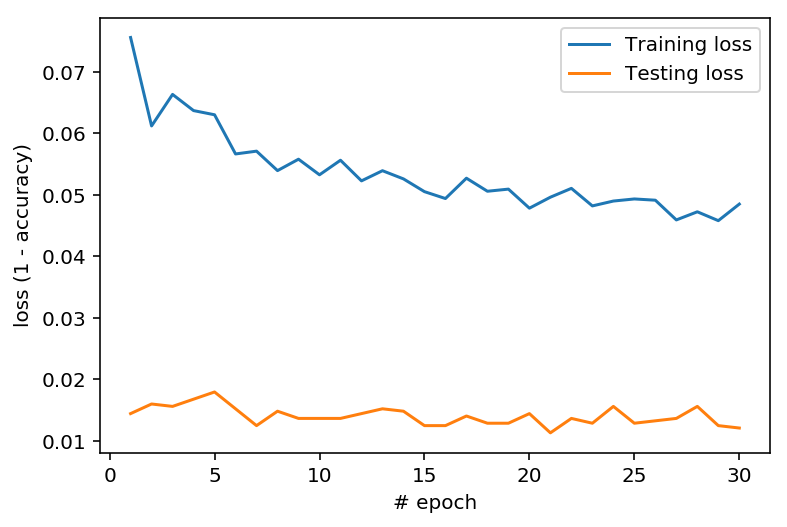

In [9]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax1 = fig.add_subplot(111)

y = [i+1 for i in range(epochs)]
ax1.plot(y, train_loss_epochs, label='Training loss')
ax1.plot(y, test_loss_epochs, label='Testing loss')
plt.legend(loc='upper right');

plt.ylabel('loss (1 - accuracy)')
plt.xlabel('# epoch')
plt.show()